# Classification de paroles de chansons de rap

###  Importation des librairies

In [22]:
### all imports 
import nbconvert
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

#nltk.download('punkt')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer ## TODO
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import FrenchStemmer

# libary for machine learning
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model  import LogisticRegression   
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier    




On part du dataframe contenant les paroles de chansons traitées avec Talend

### Pre-porocessing des donnéees pour le machine learning

Le preprocessing comporte plusieurs étapes:
 
    - Tokénization : Division d'une chaîne de caractère en tokens, cad les éléments atomiques de la chaîne. On peut avoir la tokénization par mot ou par phrase, ici, un token est un mot.
    
    - Suppression des stopwords : stopword == mot très fréquents dans la langue donc qui va juste rajouter du bruit 
    
    - Stemming: fait de garder seulemnt la racine des mots, permet de diminuer la taille de notre base de données


In [23]:
# Chargement des données 

# la base de données
Corpus = pd.read_excel("ParolesFinalNettoyer_derniereVersion.xlsx",encoding = 'utf-8')  # index, label, paroles

# les stopwords
stopWords=[]
with open("stopwords.txt", "r", encoding="utf-8") as f:
    for i in f:
        stopWords.append(i.strip('\n'))

In [24]:
Corpus

,INDEX,LABEL,PAROLES
0,11,1,dix grammes de zeb dans le cerveau je sais qu...
1,16,1,j suisa se l ai j suis dans le binks binks bi...
2,19,1,genre c est la sere mi mec on s lavaita cinq ...
3,21,0,oh oh oh combien de soucis combien de nuita d...
4,22,1,peter les plombs et faire les pas ou bien bai...
...,...,...,...
488,4505,1,et voila summer crack mec ca arrivea sa putai...
489,4513,1,he yeah yeah c que j veux c est que ce client...
490,4524,0,la guerra la guerra valar morghulis ah specta...
491,4529,1,attable pas loin du fumoir yeah skur skur qua...


In [25]:
# Tokenisation
Corpus['PAROLES']= [word_tokenize(entry) for entry in Corpus['PAROLES']] 

In [26]:
# Stemming et suppression des stopwords
stemmer= FrenchStemmer()
for index,entry in enumerate(Corpus['PAROLES']): 
    final_words = []
    for word in entry:
        if word not in stopWords and word.isalpha():# si word n'est pas un stopW et est un alphabet
            final_words.append(stemmer.stem(word)) # append -> ajouter
# Creation d'un corpus constitué de toutes les paroles de la base de données processées pour le Machine Learning
    Corpus.loc[index,'text_final'] = str(" ".join(final_words)) 

### Preparation du train_data et test_data

In [27]:
# split data en data_train(0.75) et data_test(0.25)
# paramètre 'stratify' pour garder la même proportion dans le test et le train 

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['LABEL'],test_size=0.2, random_state = 1, stratify = Corpus['LABEL'])


### Creation des matrices de mot (=bag of word) 

    Les algorithmes de machine learning ne sont pas adaprtées au mots. Il faut donc utiliser des methods permettant de converir un document en une matrice de mot avec la fonction CountVectorizer() de sklearn.
    A la suite de fonction Countvectorizer, on va  utiliser la fontion TfidfTransformer qui applique l'approche TFIDF () à la matrice.
    TfidfTransformer : donne un poids au token en prenant en compte la frequence du token dans la chansoon (d'interêt) et la frequence du token dans l'ensomble des chansons

In [28]:
vect = CountVectorizer(binary = True, min_df = 10) # min_df = 10 --> ignorez les termes de fréquence <10
vect.fit(Train_X)
vect_Train = vect.transform(Train_X)
vect_Test  = vect.transform(Test_X)


tfidf_transformer = TfidfTransformer() # pour appliquer le tfidf à la matrice calculée avec CountVectorizer
tfidf_transformer.fit(vect_Train)
X_train_tfidf = tfidf_transformer.transform(vect_Train)
X_test_tfidf = tfidf_transformer.transform(vect_Test)

Encoder = LabelEncoder() # transformation de label de string "0" et "1" en int 0 et 1
Train_Y = Encoder.fit_transform(Train_Y) 
Test_Y  = Encoder.fit_transform(Test_Y)  

In [29]:
print(X_test_tfidf)

  (0, 1411)	0.13340867348656726
  (0, 1405)	0.081271856845512
  (0, 1393)	0.13980813483048135
  (0, 1391)	0.11213339089069614
  (0, 1348)	0.0968537869957485
  (0, 1336)	0.09388583440943161
  (0, 1335)	0.14551252670417886
  (0, 1333)	0.13340867348656726
  (0, 1324)	0.13490251004695145
  (0, 1310)	0.14551252670417886
  (0, 1305)	0.15773804334078245
  (0, 1289)	0.13809560683842192
  (0, 1286)	0.13646276074491132
  (0, 1263)	0.07492762739534961
  (0, 1202)	0.09898170280902852
  (0, 1197)	0.08740740821503228
  (0, 1196)	0.07003402105440815
  (0, 1188)	0.08586430868342226
  (0, 1170)	0.12016569832812084
  (0, 1147)	0.08943686712999155
  (0, 1102)	0.1233110726632437
  (0, 1101)	0.10835556951273782
  (0, 1094)	0.15773804334078245
  (0, 1091)	0.08438620139116446
  (0, 1090)	0.08366985282891291
  :	:
  (98, 478)	0.11400931579661494
  (98, 458)	0.08969457231602285
  (98, 456)	0.14575704296383965
  (98, 454)	0.131531726100836
  (98, 431)	0.14103156577310805
  (98, 373)	0.10331721637543469
  (98, 3

### Application de modèles de Machine learning

### Regression Logistique
    La régression logistique est une technique prédictive. Elle vise à construire un modèle permettant de prédire / expliquer les valeurs prises par une variable cible qualitative (ici, adapté/non adapté) à partir d’un ensemble de variables explicatives quantitatives ou qualitatives (ici paroles de chansons).

In [30]:
# Entrainement du modèle
regLog = LogisticRegression()
regLog.fit(X_train_tfidf, Train_Y)

# Prediction des label sur les donées test
predictions_regLog = regLog.predict(X_test_tfidf) 
predictions_regLog

with open('classifier_Regression.pkl', 'wb') as f:
    pickle.dump(regLog, f)

# Calcul des performances
accuracy_score_reg = accuracy_score(Test_Y, predictions_regLog)
precision_score_reg = precision_score(Test_Y, predictions_regLog)
recall_score_reg = recall_score(Test_Y, predictions_regLog)
f1_score_reg = f1_score(Test_Y, predictions_regLog)

print(accuracy_score_reg, precision_score_reg, recall_score_reg, f1_score_reg )

print(confusion_matrix(Test_Y, predictions_regLog)) # Diagonale == > reponses correctes

0.7272727272727273 0.78125 0.5555555555555556 0.6493506493506493
[[47  7]
 [20 25]]


In [31]:
# extraction des features avec leur poids 
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, Train_Y)

coef_abs = np.abs(logreg.coef_[0,:])
thresholds = np.percentile(coef_abs,[0,25,50,75,90,100])
indices = np.where(coef_abs > thresholds[1])
#termes selectionnés 
sel_terms = np.array(vect.get_feature_names()) 
#les indices triés par valeur absolue des coefficients de  
sorted_indices = np.argsort(logreg.coef_[0,:]) 
#print les termes et leurs coefficients 
imp = {'term':np.asarray(sel_terms)[sorted_indices],'coef':logreg.coef_[0,:][sorted_indices]} 
print(pd.DataFrame(imp).head())

# Corpus.to_csv("word_cloud.csv")

    term      coef
0  pourt -0.650052
1    mic -0.594835
2   jeun -0.589769
3  laiss -0.561474
4  mieux -0.552579


### Naive Classifier Methode 1
    Le Naïves Bayes est un algorithme probabiliste. L’approche probabiliste voit la fonction de classification en terme de probabilité qu’un document représenté par le vecteur di = (wi2, wi3, wi4, ....., wi|T|) (avec |T| le nombre de termes ou de caractéristiques de documents) appartienne à la classe ck. Elle calcule cette probabilité par l’application du théorème de Bayes

In [32]:
# Entrainement du modèle NB Bayes
NB = naive_bayes.MultinomialNB() 
NB.fit(X_train_tfidf,Train_Y)  

# Prediction des label sur les donées test
predictions_NB = NB.predict(X_test_tfidf) 

# Sauver pour pouvoir appeler le modèle sans lancer tout le processus fit 
with open('classifier_NB.pkl', 'wb') as f:  
    pickle.dump(NB, f)

# Calcul des performances
accuracy_score_NB = accuracy_score(Test_Y, predictions_NB)
precision_score_NB = precision_score(Test_Y, predictions_NB)
recall_score_NB = recall_score(Test_Y, predictions_NB)
f1_score_NB = f1_score(Test_Y, predictions_NB)

print(accuracy_score_NB, precision_score_NB, recall_score_NB, f1_score_NB )

print(confusion_matrix(Test_Y, predictions_NB)) # Diagonale == > reponses correctes

0.7676767676767676 0.8055555555555556 0.6444444444444445 0.7160493827160493
[[47  7]
 [16 29]]


In [33]:
# extraction des features avec leur poids 
Naive = naive_bayes.MultinomialNB() 
Naive.fit(X_train_tfidf,Train_Y)  

coef_abs = np.abs(Naive.coef_[0,:])
thresholds = np.percentile(coef_abs,[0,25,50,75,90,100])
indices = np.where(coef_abs > thresholds[1])
# 
sel_terms = np.array(vect.get_feature_names()) 
# 
sorted_indices = np.argsort(Naive.coef_[0,:]) 
#  
imp = {'term':np.asarray(sel_terms)[sorted_indices],'coef':Naive.coef_[0,:][sorted_indices]} 
print(pd.DataFrame(imp).head())
pd.DataFrame(imp).to_csv("word_cloud_NaiveBayes.csv")

        term      coef
0  akhenaton -8.073421
1     shurik -8.073421
2     courag -8.073421
3    medecin -8.003032
4      prier -7.982796


### Support vector machine methode 2  SVM
    Un Support Vector Machine est un algorithme permettant de réaliser des tâches de classification ou de régression. Il fonctionne bien sur des données textuelles de classification.
    Supposons qu’il existe deux classes de données. Un Support Vector Machine trouvera un hyperplan ou une frontière entre les deux classes de données qui maximisera la marge entre les deux classes. Il y a plusieurs plans qui peuvent séparer les deux classes, mais un seul plan peut maximiser la distance entre les classes.

In [34]:
# Entrainement du modèle SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=4, gamma='auto') # 
SVM.fit(X_train_tfidf,Train_Y)

predictions_SVM = SVM.predict(X_test_tfidf)

with open('classifier_SVM.pkl', 'wb') as f:  
    pickle.dump(SVM, f)

# Calcul des performances
accuracy_score_SVM = accuracy_score(Test_Y, predictions_SVM)
precision_score_SVM = precision_score(Test_Y, predictions_SVM)
recall_score_SVM = recall_score(Test_Y, predictions_SVM)
f1_score_SVM = f1_score(Test_Y, predictions_SVM)

print(accuracy_score_SVM, precision_score_SVM, recall_score_SVM, f1_score_SVM )

print(confusion_matrix(Test_Y, predictions_SVM))

0.7777777777777778 0.8108108108108109 0.6666666666666666 0.7317073170731707
[[47  7]
 [15 30]]


### Évaluation des modèles

    Ici, on évalue le performances de nos différents modèles en se basant sur les metrics suivantes :
    • La précision correspond à la proportion de résultats réels sur tous les résultats positifs. Elle indique à quel point les prédictions positives sont précises (Précision = TP/(TP+FP) )
    • Le Rappel (sensibilité) indique quelle proportion de résultats positifs réels a été identifiée correctement? (Rappel = TP/(TP+FN) )
    • Le score F1  est calculé comme la moyenne pondérée de précision et de rappel comprise entre  et 1, la valeur de score F1 idéale étant 1. (F1 = 2TP /2TP+FP+FN) 


On trouve les tables de confusions suivantes pour les différents modèles:
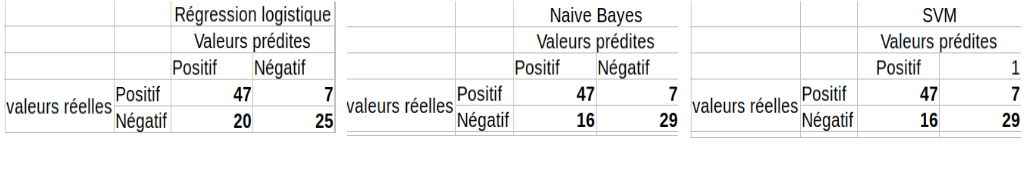


On en déduis alors les performances des modèles récapitulées dans le tableau ci dessous.

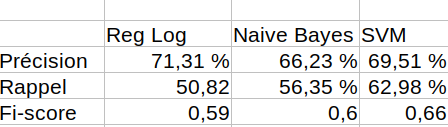


Pour évaluer les performances d'un modèle de façon complète, on analyse à la fois la précision et le rappel. Malheureusement, précision et rappel sont fréquemment en tension. Le score F 1 est un outil statistique créé pour évaluer simultanément la précision et le rappel. C’est une moyenne harmonique de précision et de rappel, plus le rappel ET la précision sont élevés, plus le F-score est élevé, Et en se basant sur le score F1, le **SVM est le modèle le plus performant.**

### Ensemble learning
    Construire un nouveau modèle en utilisant un système de vote sur les predictions des diférents modèles déjà construits(SVM, Naive bayes et Regression logistique).

In [ ]:

modeles = VotingClassifier([('SVM', SVM), ('Naive', Naive), ('logist', logreg)], voting='hard') # voting='hard' --> vote sur les predictions
modeles.fit(X_train_tfidf,Train_Y)
predictions_VC = modeles.predict(X_test_tfidf)

# Calcul des performances
accuracy_score_VC = accuracy_score(Test_Y, predictions_VC)
precision_score_VC = precision_score(Test_Y, predictions_VC)
recall_score_VC = recall_score(Test_Y, predictions_VC)
f1_score_VC = f1_score(Test_Y, predictions_VC)

print(accuracy_score_VC, precision_score_VC, recall_score_VC, f1_score_VC )

print(confusion_matrix(Test_Y, predictions_vote))

Ci-dessous, le recapitulatif des perfomances
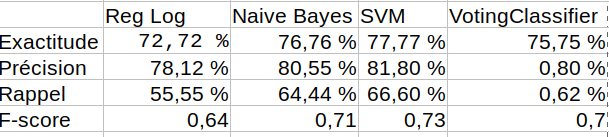

In [ ]:
from sklearn.ensemble import VotingClassifier    

modeles = VotingClassifier([('SVM', SVM), ('Naive', Naive), ('logist', logreg)], voting='hard') # voting='hard' --> vote sur les predictions
modeles.fit(X_train_tfidf,Train_Y)
predictions_vote = modeles.predict(X_test_tfidf)

for modele in (SVM, Naive, logreg, modeles):
    modele.fit(X_train_tfidf,Train_Y)
    print(modele.__class__.__name__, modele.score(X_test_tfidf, Test_Y))